In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Bidirectional
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Load the datasets
gold_price_data = pd.read_csv('dataset/ADANIENT.NS.csv')

# Display the first few rows of each dataset to understand their structure
print("Gold Price Data:")
print(gold_price_data.head())

# Preprocessing
gold_price_data.isna().sum().sum()
gold_price_data.dropna(inplace=True)

gold_price_data['Date'] = pd.to_datetime(gold_price_data['Date'])
gold_price_data.set_index('Date', inplace=True)
gold_price_data = gold_price_data.sort_index()

Gold Price Data:
         Date      Open      High       Low     Close  Adj Close     Volume
0  2002-07-01  1.364148  1.401700  1.334259  1.362615  -0.010452  1080397.0
1  2002-07-02  1.386372  1.390971  1.356484  1.373344  -0.010535  1016147.0
2  2002-07-03  1.371811  1.387139  1.364914  1.373344  -0.010535   980394.0
3  2002-07-04  1.379475  1.401700  1.379475  1.381008  -0.010593   972747.0
4  2002-07-05  1.388672  1.388672  1.372578  1.377942  -0.010570   974496.0


In [4]:
gold_price_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-07-01,1.364148,1.401700,1.334259,1.362615,-0.010452,1080397.0
2002-07-02,1.386372,1.390971,1.356484,1.373344,-0.010535,1016147.0
2002-07-03,1.371811,1.387139,1.364914,1.373344,-0.010535,980394.0
2002-07-04,1.379475,1.401700,1.379475,1.381008,-0.010593,972747.0
2002-07-05,1.388672,1.388672,1.372578,1.377942,-0.010570,974496.0
...,...,...,...,...,...,...
2024-04-30,3094.000000,3108.449951,3045.000000,3054.699951,3054.699951,804552.0
2024-05-02,3071.949951,3119.850098,3015.050049,3039.600098,3039.600098,2219085.0
2024-05-03,3030.000000,3045.000000,2975.100098,2993.250000,2993.250000,1472168.0


In [3]:
# Use only the 'Close' price for prediction
data = gold_price_data['Close'].values
data = data.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [4]:
def create_dataset(data, window_size=1):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        a = data[i:(i + window_size), 0]
        X.append(a)
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

In [5]:
window_size = 60  # You can adjust this window size
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Reshape input to be [samples, time steps, features] for LSTM/RNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [6]:
# Bidirectional LSTM model
model_bi_lstm = Sequential()
model_bi_lstm.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(window_size, 1))))
model_bi_lstm.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model_bi_lstm.add(Dense(units=25))
model_bi_lstm.add(Dense(units=1))
model_bi_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_bi_lstm.fit(X_train, y_train, batch_size=1, epochs=1)

4279/4279 [==============================] - 60s 13ms/step - loss: 7.0564e-06


In [7]:
# RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=50, return_sequences=True, input_shape=(window_size, 1)))
model_rnn.add(SimpleRNN(units=50, return_sequences=False))
model_rnn.add(Dense(units=25))
model_rnn.add(Dense(units=1))

model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.fit(X_train, y_train, batch_size=1, epochs=1)

4279/4279 [==============================] - 36s 8ms/step - loss: 2.5709e-05


In [8]:
# CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(units=50))
model_cnn.add(Dense(units=1))

model_cnn.compile(optimizer='adam', loss='mean_squared_error')
model_cnn.fit(X_train, y_train, batch_size=1, epochs=1)

4279/4279 [==============================] - 6s 1ms/step - loss: 8.3469e-06


In [9]:
# Function to predict and inverse transform the data
def predict_and_inverse_transform(model, X, y):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(predictions)
    y = scaler.inverse_transform([y])
    return predictions, y


In [10]:
# Predict using Bidirectional LSTM
predictions_bi_lstm, y_test_bi_lstm = predict_and_inverse_transform(model_bi_lstm, X_test, y_test)

# Predict using RNN
predictions_rnn, y_test_rnn = predict_and_inverse_transform(model_rnn, X_test, y_test)

# Predict using CNN
predictions_cnn, y_test_cnn = predict_and_inverse_transform(model_cnn, X_test, y_test)

33/33 [==============================] - 0s 1ms/step


In [11]:
# Calculate MAE and MSE
mae_bi_lstm = mean_absolute_error(y_test_bi_lstm[0], predictions_bi_lstm)
mse_bi_lstm = mean_squared_error(y_test_bi_lstm[0], predictions_bi_lstm)

mae_rnn = mean_absolute_error(y_test_rnn[0], predictions_rnn)
mse_rnn = mean_squared_error(y_test_rnn[0], predictions_rnn)

mae_cnn = mean_absolute_error(y_test_cnn[0], predictions_cnn)
mse_cnn = mean_squared_error(y_test_cnn[0], predictions_cnn)

In [12]:
# Calculate MAE and MSE percentages
mean_actual = np.mean(y_test_bi_lstm[0])
mae_bi_lstm_pct = (mae_bi_lstm / mean_actual) * 100
mse_bi_lstm_pct = (mse_bi_lstm / mean_actual) * 100

mae_rnn_pct = (mae_rnn / mean_actual) * 100
mse_rnn_pct = (mse_rnn / mean_actual) * 100

mae_cnn_pct = (mae_cnn / mean_actual) * 100
mse_cnn_pct = (mse_cnn / mean_actual) * 100

# Calculate Accuracy
accuracy_bi_lstm = 100 - mae_bi_lstm_pct
accuracy_rnn = 100 - mae_rnn_pct
accuracy_cnn = 100 - mae_cnn_pct

In [13]:
# Print MAE and MSE percentages and accuracies
print(f'Bidirectional LSTM - MAE: {mae_bi_lstm_pct}%, MSE: {mse_bi_lstm_pct}%, Accuracy: {accuracy_bi_lstm}%')
print(f'RNN - MAE: {mae_rnn_pct}%, MSE: {mse_rnn_pct}%, Accuracy: {accuracy_rnn}%')
print(f'CNN - MAE: {mae_cnn_pct}%, MSE: {mse_cnn_pct}%, Accuracy: {accuracy_cnn}%')

Bidirectional LSTM - MAE: 5.372399687090628%, MSE: 1545.7422321126774%, Accuracy: 94.62760031290938%
RNN - MAE: 11.610792042706533%, MSE: 4906.242487141625%, Accuracy: 88.38920795729346%
CNN - MAE: 5.93501926009697%, MSE: 1885.5216845409914%, Accuracy: 94.06498073990304%


In [14]:
# Plot bar graph for MAE and MSE percentages
models = ['Bidirectional LSTM', 'RNN', 'CNN']
mae_percentages = [mae_bi_lstm_pct, mae_rnn_pct, mae_cnn_pct]
mse_percentages = [mse_bi_lstm_pct, mse_rnn_pct, mse_cnn_pct]

Text(0.5, 1.0, 'MAE Percentage for Models')

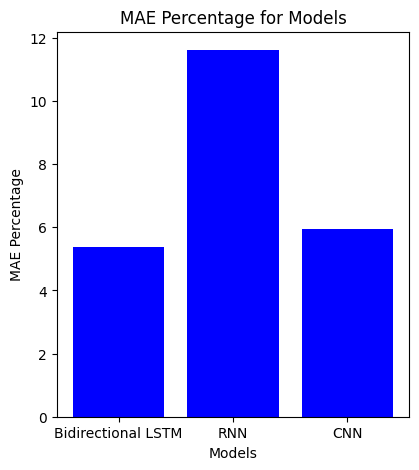

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, mae_percentages, color='blue')
plt.xlabel('Models')
plt.ylabel('MAE Percentage')
plt.title('MAE Percentage for Models')

Text(0.5, 1.0, 'MSE Percentage for Models')

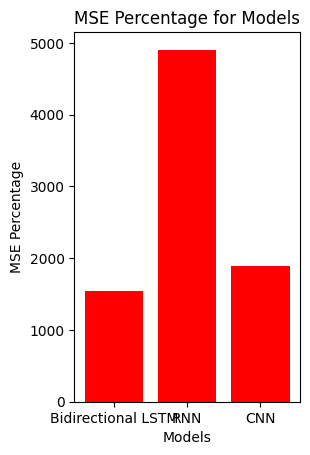

In [16]:
plt.subplot(1, 2, 2)
plt.bar(models, mse_percentages, color='red')
plt.xlabel('Models')
plt.ylabel('MSE Percentage')
plt.title('MSE Percentage for Models')

In [17]:

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

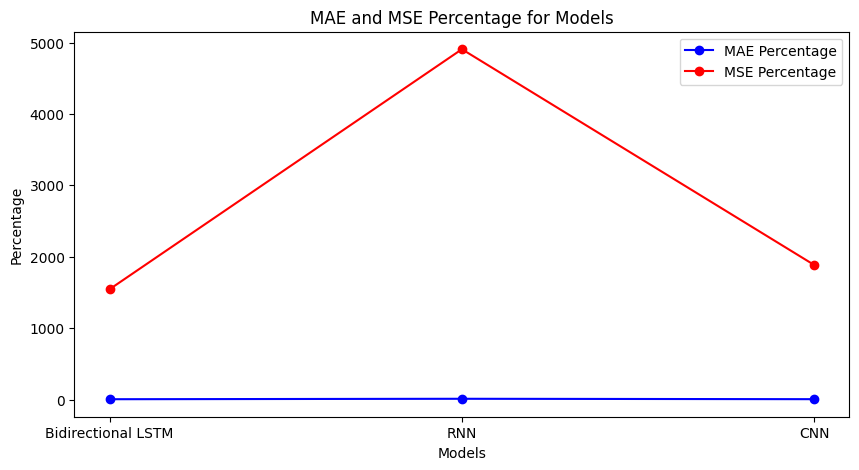

In [18]:
# Plot line graph for MAE and MSE
plt.figure(figsize=(10, 5))
plt.plot(models, mae_percentages, marker='o', label='MAE Percentage', color='blue')
plt.plot(models, mse_percentages, marker='o', label='MSE Percentage', color='red')
plt.xlabel('Models')
plt.ylabel('Percentage')
plt.title('MAE and MSE Percentage for Models')
plt.legend()
plt.show()